In [1]:
import pandas as pd
import numpy as np
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
%matplotlib inline

C:\Users\miche\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
series = pd.read_csv('sine-wave.csv', header=None ) #leitura do arquivo execel variação de 1 a -1, onda senoidal simples.

In [3]:
series.head()

,0
0,0.841471
1,0.873736
2,0.902554
3,0.927809
4,0.949402


In [4]:
series.shape #amostra com 5k1 linhas e 1 coluna

(5001, 1)

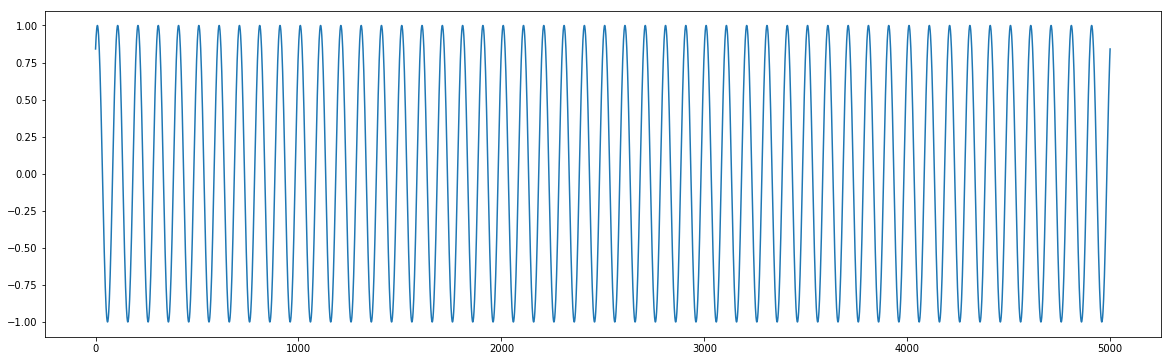

In [5]:
#poltando a senoide
pyplot.figure(figsize=(20,6))
pyplot.plot(series.values)
pyplot.show()

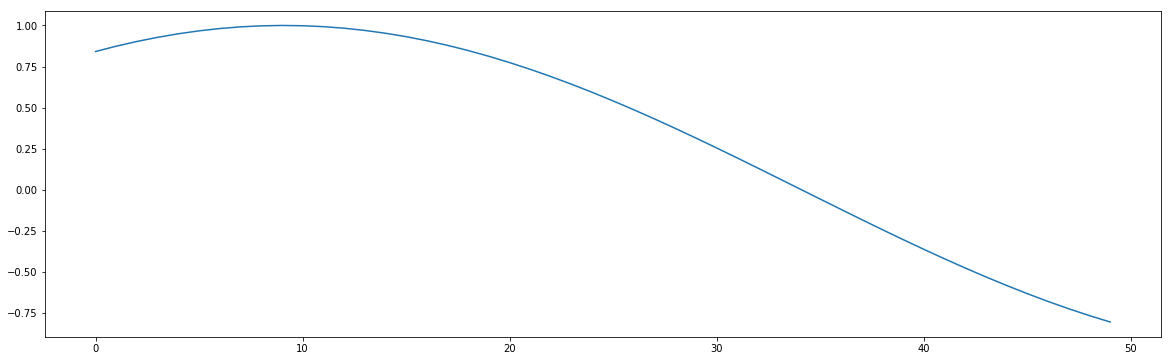

In [6]:
#selecionando as primeiras 50 amostras, Amplitude de 1
#aprenda a onda do pecado a partir de um tamanho de 
#janela de conjunto de dados que iremos alimentá-lo
#e esperamos poder pedir ao LSTM que preveja os próximos N passos da série e ele continuará cuspindo o pecado onda.
pyplot.figure(figsize=(20,6))
pyplot.plot(series.values[:50])
pyplot.show()

In [7]:
#Normalizando os dados usando o minmax scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(series.values)
series = pd.DataFrame(scaled)

In [8]:
#Fixe o tamanho da janela móvel em 50. 
#Usar a função pandas shift, 
#que desloca a coluna inteira pelo número que especificamos.
#No trecho de código abaixo, é aumentando a coluna em 1 (portanto, usamos -1. Se quisermos alterá- la em 1, teremos que usar +1)
#e então concatenar isso com os dados originais.
window_size = 50
series_s = series.copy()
for i in range(window_size):
    series = pd.concat([series, series_s.shift(-(i+1))], axis = 1)
    
series.dropna(axis=0, inplace=True)

In [9]:
#O segundo elemento de cada coluna é o primeiro da proxima coluna, mas só para os primeiros 50 termos
series.head()

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0.841483,0.873749,0.902566,0.927822,0.949416,0.967263,0.981292,0.991449,0.997693,1.000000,...,-0.420975,-0.477101,-0.531344,-0.583490,-0.633333,-0.680677,-0.725334,-0.767129,-0.805896,-0.841483
1,0.873749,0.902566,0.927822,0.949416,0.967263,0.981292,0.991449,0.997693,1.000000,0.998360,...,-0.477101,-0.531344,-0.583490,-0.633333,-0.680677,-0.725334,-0.767129,-0.805896,-0.841483,-0.873749
2,0.902566,0.927822,0.949416,0.967263,0.981292,0.991449,0.997693,1.000000,0.998360,0.992780,...,-0.531344,-0.583490,-0.633333,-0.680677,-0.725334,-0.767129,-0.805896,-0.841483,-0.873749,-0.902566
3,0.927822,0.949416,0.967263,0.981292,0.991449,0.997693,1.000000,0.998360,0.992780,0.983282,...,-0.583490,-0.633333,-0.680677,-0.725334,-0.767129,-0.805896,-0.841483,-0.873749,-0.902566,-0.927822
4,0.949416,0.967263,0.981292,0.991449,0.997693,1.000000,0.998360,0.992780,0.983282,0.969904,...,-0.633333,-0.680677,-0.725334,-0.767129,-0.805896,-0.841483,-0.873749,-0.902566,-0.927822,-0.949416


In [10]:
series.shape

(4951, 51)

In [11]:
#pega a quantidade de linhas * 0.8 = pega 80% pra treino e o resto pra teste
nrow = round(0.8*series.shape[0])
train = series.iloc[:nrow, :]
test = series.iloc[nrow:,:]

In [12]:
#Alinhamentos aleatórios ou matrizes esparsas de maneira consistente. Usado em 
from sklearn.utils import shuffle
train = shuffle(train)

In [13]:
train

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2132,0.130601,0.068090,0.005310,-0.057491,-0.120065,-0.182166,-0.243547,-0.303967,-0.363188,-0.420975,...,-0.641515,-0.592081,-0.540310,-0.486407,-0.430584,-0.373061,-0.314067,-0.253833,-0.192597,-0.130601
394,0.583490,0.633333,0.680677,0.725334,0.767129,0.805896,0.841483,0.873749,0.902566,0.927822,...,-0.057491,-0.120065,-0.182166,-0.243547,-0.303967,-0.363188,-0.420975,-0.477101,-0.531344,-0.583490
2943,-0.531344,-0.583490,-0.633333,-0.680677,-0.725334,-0.767129,-0.805896,-0.841483,-0.873749,-0.902566,...,-0.005310,0.057491,0.120065,0.182166,0.243547,0.303967,0.363188,0.420975,0.477101,0.531344
2178,-0.373061,-0.314067,-0.253833,-0.192597,-0.130601,-0.068090,-0.005310,0.057491,0.120065,0.182166,...,0.812138,0.773898,0.732603,0.688418,0.641515,0.592081,0.540310,0.486407,0.430584,0.373061
145,-0.633333,-0.680677,-0.725334,-0.767129,-0.805896,-0.841483,-0.873749,-0.902566,-0.927822,-0.949416,...,0.120065,0.182166,0.243547,0.303967,0.363188,0.420975,0.477101,0.531344,0.583490,0.633333
3716,0.907088,0.878865,0.847173,0.812138,0.773898,0.732603,0.688418,0.641515,0.592081,0.540310,...,-0.991449,-0.997693,-1.000000,-0.998360,-0.992780,-0.983282,-0.969904,-0.952697,-0.931731,-0.907088
1199,0.805896,0.841483,0.873749,0.902566,0.927822,0.949416,0.967263,0.981292,0.991449,0.997693,...,-0.363188,-0.420975,-0.477101,-0.531344,-0.583490,-0.633333,-0.680677,-0.725334,-0.767129,-0.805896
2084,-0.005310,0.057491,0.120065,0.182166,0.243547,0.303967,0.363188,0.420975,0.477101,0.531344,...,0.540310,0.486407,0.430584,0.373061,0.314067,0.253833,0.192597,0.130601,0.068090,0.005310
511,0.992780,0.983282,0.969904,0.952697,0.931731,0.907088,0.878865,0.847173,0.812138,0.773898,...,-0.902566,-0.927822,-0.949416,-0.967263,-0.981292,-0.991449,-0.997693,-1.000000,-0.998360,-0.992780
3468,-0.847173,-0.812138,-0.773898,-0.732603,-0.688418,-0.641515,-0.592081,-0.540310,-0.486407,-0.430584,...,1.000000,0.998360,0.992780,0.983282,0.969904,0.952697,0.931731,0.907088,0.878865,0.847173


In [14]:
#separa x,y, dado do resultado
train_X = train.iloc[:,:-1]
train_y = train.iloc[:,-1]

test_X = test.iloc[:,:-1]
test_y = test.iloc[:,-1]

In [15]:
train_X = train_X.values
train_y = train_y.values
test_X = test_X.values
test_y = test_y.values

In [16]:
#train_X.shape
#train_y.shape
#test_X.shape
test_y.shape

(990,)

In [17]:
#Dá uma nova forma a uma matriz sem alterar seus dados.
#numpy.shape(linha x coluna)
train_X = train_X.reshape(train_X.shape[0],train_X.shape[1],1) #( linha do train_X, coluna train_X, 1 ) cria um Array3D
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1],1)

In [18]:
train_X.shape
#train_y.shape
#test_X.shape
#test_y.shape

(3961, 50, 1)

In [19]:
# Definicao do modelo LSTM
# estrutura de rede de [1, 50, 256, 1] onde temos 1 camada de entrada (50,1) 
# (consistindo de uma seqüência de tamanho 50) 
# que alimenta uma camada LSTM com 50 neurônios, 
# que por sua vez alimenta outra camada LSTM com 256 neurônios 
# que então se alimentam em uma camada normal 
# totalmente conectada de 1 neurônio [Dense(1)] 
# com uma função de ativação linear 
# que será usada para dar a previsão do próximo passo de tempo.
model = Sequential()
model.add(LSTM(input_shape = (50,1), output_dim= 50, return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(256))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss="mse", optimizer="adam")
model.summary()

C:\Users\miche\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(50, 1), return_sequences=True, units=50)`
  # This is added back by InteractiveShellApp.init_path()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               314368    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 325,025
Trainable params: 325,025
Non-trainable params: 0
_________________________________________________________________


In [20]:
start = time.time()
#aqui fita, ou melhor treina o modelo para predizer os resultados... blocos de 512 com 3 épocas
model.fit(train_X,train_y,batch_size=512,nb_epoch=3,validation_split=0.1)
print("> Compilation Time : ", time.time() - start)

C:\Users\miche\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 3564 samples, validate on 397 samples
Epoch 1/3
3564/3564 [==============================] - 7s 2ms/step - loss: 0.2828 - val_loss: 0.0766
Epoch 2/3
3564/3564 [==============================] - 5s 1ms/step - loss: 0.0474 - val_loss: 0.0023
Epoch 3/3
3564/3564 [==============================] - 5s 1ms/step - loss: 0.0211 - val_loss: 2.7576e-04
> Compilation Time :  18.306535720825195


In [24]:
# aqui está predizendo,
preds = model.predict(test_X)

In [25]:
#preds = scaler.inverse_transform(preds)
#actuals = scaler.inverse_transform(test_y)
actuals = test_y

In [27]:
mean_squared_error(actuals,preds)

0.0002827319476080473

Text(0.5,1,'Atual')

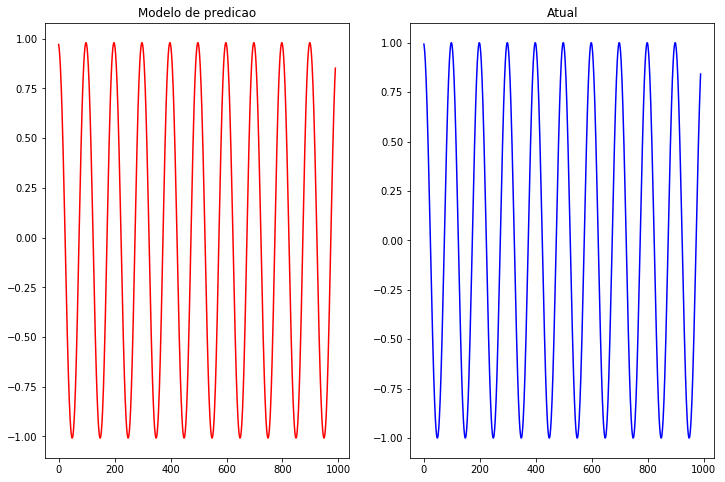

In [35]:
fig, ax = pyplot.subplots(1,2, figsize=(12,8))
ax[0].plot(preds,'r-')
titulo = 'Modelo de predicao'
ax[0].set_title(titulo)

ax[1].plot(actuals,'b-')
titulo = 'Atual'
ax[1].set_title(titulo)

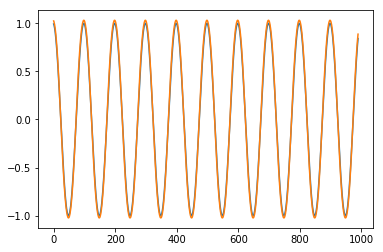

In [107]:
pyplot.plot(actuals)
pyplot.plot(preds)
pyplot.show()

In [132]:
def moving_test_window_preds(n_future_preds):

    ''' n_future_preds - Represents the number of future predictions we want to make
                         This coincides with the number of windows that we will move forward
                         on the test data
    '''
    preds_moving = []                                    # Use this to store the prediction made on each test window
    moving_test_window = [test_X[0,:].tolist()]          # Creating the first test window
    moving_test_window = np.array(moving_test_window)    # Making it an numpy array
    
    for i in range(n_future_preds):
        preds_one_step = model.predict(moving_test_window) # Note that this is already a scaled prediction so no need to rescale this
        preds_moving.append(preds_one_step[0,0]) # get the value from the numpy 2D array and append to predictions
        preds_one_step = preds_one_step.reshape(1,1,1) # Reshaping the prediction to 3D array for concatenation with moving test window
        moving_test_window = np.concatenate((moving_test_window[:,1:,:], preds_one_step), axis=1) # This is the new moving test window, where the first element from the window has been removed and the prediction  has been appended to the end
        
    preds_moving = scaler.inverse_transform(preds_moving)
    
    return preds_moving
        

In [133]:
preds_moving = moving_test_window_preds(500)

C:\Users\kmsra_000\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


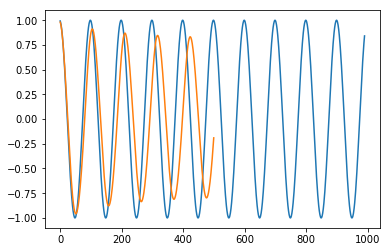

In [134]:
pyplot.plot(actuals)
pyplot.plot(preds_moving)
pyplot.show()